# Trauma Transfer Learning Experiment

This notebook compares baseline survival models and a transfer learning approach using Indian and Jordan trauma datasets.

In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from lifelines import CoxPHFitter, KaplanMeierFitter
from lifelines.utils import concordance_index
from sksurv.ensemble import GradientBoostingSurvivalAnalysis
#
sns.set(style='whitegrid')


## Load datasets

In [52]:
india_file = 'trauma_india_brain_injury.csv'
jordan_file = 'traumatic_brain_injury.csv'

cols_india = ['age','sex','sbp_1','hr_1','rr_1','gcs_t_1','doa','toa','dodd','todd','moi','died']
india = pd.read_csv(india_file, usecols=cols_india)

cols_jordan = ['Gender','age of diagnosis','ER-HR','ER-RR','ER-systolic BP','GCS in ER','type of trauma','length of stay in the hospital (in days)','outcome']
jordan = pd.read_csv(jordan_file, usecols=cols_jordan)


In [53]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

# Select only numeric columns for imputation
jordan_numeric = jordan.select_dtypes(include=[np.number])

# Perform iterative imputation
imputer = IterativeImputer(random_state=0)
jordan_imputed_array = imputer.fit_transform(jordan_numeric)

# Replace numeric columns in jordan with imputed values
jordan[jordan_numeric.columns] = jordan_imputed_array

print(jordan.head())

   Gender  age of diagnosis   type of trauma  GCS in ER        ER-HR  \
0  Female               6.0  RTA(PEDASTRAIN)       15.0  tachycardia   
1    Male               7.0  RTA(PEDASTRAIN)       15.0       normal   
2    Male              13.0     falling down        3.0       normal   
3    Male               9.0              RTA       13.0       normal   
4    Male               1.5     falling down       15.0       normal   

       ER-RR ER-systolic BP  length of stay in the hospital (in days)  \
0  tachypnea         normal                                       5.0   
1     normal         normal                                       7.0   
2     normal         normal                                       7.0   
3     normal         normal                                      28.0   
4     normal         normal                                       3.0   

    outcome  
0  survival  
1  survival  
2  survival  
3  survival  
4  survival  


## Feature engineering

In [54]:
# Pediatric reference ranges (example, adjust as needed for your population)
def hr_category(age, hr):
    # Age in years, HR in bpm
    if pd.isnull(hr) or pd.isnull(age):
        return np.nan
    if age < 1:
        if hr > 160: return 'tachycardia'
        else: return 'normal'
    elif age < 3:
        if hr > 150: return 'tachycardia'
        else: return 'normal'
    elif age < 6:
        if hr > 140: return 'tachycardia'
        else: return 'normal'
    elif age < 12:
        if hr > 120: return 'tachycardia'
        else: return 'normal'
    else:
        if hr > 100: return 'tachycardia'
        else: return 'normal'

def rr_category(age, rr):
    # Age in years, RR in breaths/min
    if pd.isnull(rr) or pd.isnull(age):
        return np.nan
    if age < 1:
        if rr > 60: return 'tachypnea'
        else: return 'normal'
    elif age < 3:
        if rr > 40: return 'tachypnea'
        else: return 'normal'
    elif age < 6:
        if rr > 34: return 'tachypnea'
        else: return 'normal'
    elif age < 12:
        if rr > 30: return 'tachypnea'
        else: return 'normal'
    else:
        if rr > 20: return 'tachypnea'
        else: return 'normal'

def sbp_category(age, sbp):
    # Age in years, SBP in mmHg
    if pd.isnull(sbp) or pd.isnull(age):
        return np.nan
    if age < 1:
        if sbp < 70: return 'low'
        else: return 'normal'
    elif age < 10:
        if sbp < 70 + 2*age: return 'low'
        else: return 'normal'
    else:
        if sbp < 90: return 'low'
        else: return 'normal'



In [55]:
def normalize_india_moi(moi):
    """
    Consolidates India's MOI categories:
    Groups motorcyclist, bicyclist, unspecified under 'unspecified'.
    """
    if pd.isnull(moi):
        return 'Unmapped'

    moi = moi.strip()

    if moi in [
        'Road traffic injury (motorcyclist)',
        'Road traffic injury (bicyclist)',
        'Road traffic injury (unspecified)'
    ]:
        return 'Road traffic injury (unspecified)'

    return moi


In [56]:
def get_mode_of_injury(jordan_trauma):
    """
    Maps Jordan 'type of trauma' value to India-style 'mode_of_injury'.

    Parameters:
    - jordan_trauma: string

    Returns:
    - Standardized MOI string (India format) or 'Unmapped'
    """
    if pd.isnull(jordan_trauma):
        return 'Unmapped'
    
    mapping = {
        'RTA(PEDASTRAIN)': 'Road traffic injury (pedestrian)',
        'Falling down': 'Fall',
        'falling down': 'Fall',
        'RTA': 'Road traffic injury (unspecified)',
        'RTA ': 'Road traffic injury (unspecified)',
        'RTA(back seated)': 'Road traffic injury (passenger)',
        'RTA(first seat)': 'Road traffic injury (driver)',
        'Blast injury': 'Burn',
        'struck by a heavy object': 'Assault'
    }

    return mapping.get(jordan_trauma.strip(), 'Unmapped')


In [57]:
india['moi'] = india['moi'].apply(normalize_india_moi)
exclude_moi = ['Railway injury', 'Other', 'Unmapped']
india = india[~india['moi'].isin(exclude_moi)].copy()


In [58]:
jordan['type of trauma'] = jordan['type of trauma'].apply(get_mode_of_injury)
jordan= jordan[~jordan['type of trauma'].isin(exclude_moi)].copy()


In [59]:
def parse_datetime(date_col, time_col):
    dt = pd.to_datetime(date_col + ' ' + time_col, errors='coerce')
    return dt

india['admit_time'] = parse_datetime(india['doa'], india['toa'])
india['discharge_time'] = parse_datetime(india['dodd'], india['todd'])
india['los'] = (india['discharge_time'] - india['admit_time']).dt.total_seconds() / 3600
india['los'] = india['los'].fillna(0)
india['event'] = (india['died'] == 'Yes').astype(int)

jordan['los'] = pd.to_numeric(jordan['length of stay in the hospital (in days)'], errors='coerce')
jordan['event'] = (jordan['outcome'] == 'died').astype(int)

india['sex'] = india['sex'].map({'Male':1,'Female':0})
jordan['Gender'] = jordan['Gender'].map({'Male':1,'Female':0})

features_india = india[['age','sex','sbp_1','hr_1','rr_1','gcs_t_1','moi']].copy()
features_jordan = jordan[['age of diagnosis','Gender','ER-HR','ER-RR','ER-systolic BP','GCS in ER','type of trauma']].copy()
features_jordan.columns = ['age','sex','hr','rr','sbp','gcs','source']
features_india.columns = ['age','sex','sbp','hr','rr','gcs','source']


C:\Users\shrin\AppData\Local\Temp\ipykernel_46992\3600371442.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  dt = pd.to_datetime(date_col + ' ' + time_col, errors='coerce')
C:\Users\shrin\AppData\Local\Temp\ipykernel_46992\3600371442.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  dt = pd.to_datetime(date_col + ' ' + time_col, errors='coerce')


In [60]:
# Ensure numeric conversion for Indian vital signs before categorization
features_india['hr'] = pd.to_numeric(features_india['hr'], errors='coerce')
features_india['rr'] = pd.to_numeric(features_india['rr'], errors='coerce')
features_india['sbp'] = pd.to_numeric(features_india['sbp'], errors='coerce')
features_india['age'] = pd.to_numeric(features_india['age'], errors='coerce')

# Now apply the categorization functions
features_india['hr_cat'] = [hr_category(a, h) for a, h in zip(features_india['age'], features_india['hr'])]
features_india['rr_cat'] = [rr_category(a, r) for a, r in zip(features_india['age'], features_india['rr'])]
features_india['sbp_cat'] = [sbp_category(a, s) for a, s in zip(features_india['age'], features_india['sbp'])]

# For Jordan, use the existing categorical columns (assumed to be ER-HR, ER-RR, ER-systolic BP)
features_jordan['hr_cat'] = features_jordan['hr']
features_jordan['rr_cat'] = features_jordan['rr']
features_jordan['sbp_cat'] = features_jordan['sbp']


# Use correct argument for OneHotEncoder for scikit-learn >= 1.2
from sklearn.preprocessing import OneHotEncoder

cat_cols = ['hr_cat', 'rr_cat', 'sbp_cat','source']
enc = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

# Fit on combined categories to ensure same columns
enc.fit(pd.concat([features_india[cat_cols], features_jordan[cat_cols]], axis=0))

X_india_cat = enc.transform(features_india[cat_cols])
X_jordan_cat = enc.transform(features_jordan[cat_cols])

# Replace original columns with encoded
import numpy as np
X_india_final = np.concatenate([features_india[['age','sex','gcs']].fillna(0).values, X_india_cat], axis=1)
X_jordan_final = np.concatenate([features_jordan[['age','sex','gcs']].fillna(0).values, X_jordan_cat], axis=1)

# Update y as before
y_india = np.array([(bool(e), t) for e,t in zip(india['event'], india['los']/24)], dtype=[('event', bool), ('time', float)])
y_jordan = np.array([(bool(e), t) for e,t in zip(jordan['event'], jordan['los'])], dtype=[('event', bool), ('time', float)])


## Exploratory analysis

India rows: 7301
Jordan rows: 107
Indian LOS summary (hours):
count    7301.000000
mean      168.716537
std       308.287605
min      -240.000000
25%        43.500000
50%       108.833333
75%       191.666667
max      8936.333333
Name: los, dtype: float64
Jordan LOS summary (days):
count    107.000000
mean      11.906265
std       16.151716
min        1.000000
25%        4.000000
50%        7.000000
75%       12.000000
max      126.000000
Name: los, dtype: float64


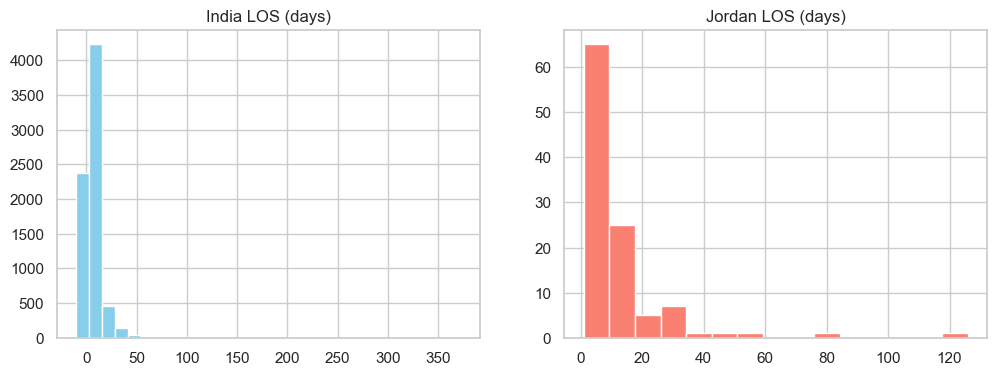

In [61]:
print('India rows:', len(india))
print('Jordan rows:', len(jordan))

print('Indian LOS summary (hours):')
print(india['los'].describe())
print('Jordan LOS summary (days):')
print(jordan['los'].describe())

fig, axes = plt.subplots(1,2, figsize=(12,4))
axes[0].hist(india['los']/24, bins=30, color='skyblue')
axes[0].set_title('India LOS (days)')
axes[1].hist(jordan['los'], bins=15, color='salmon')
axes[1].set_title('Jordan LOS (days)')
plt.show()


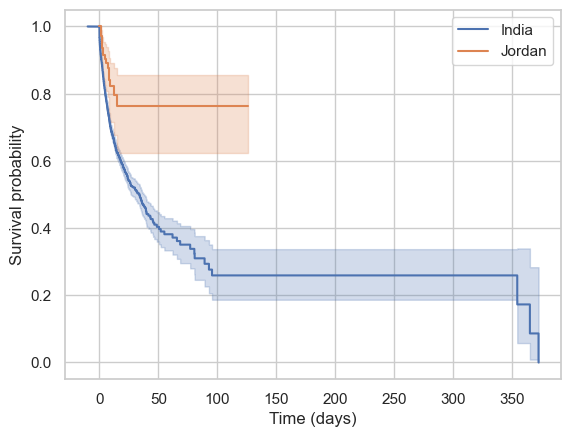

In [62]:
kmf = KaplanMeierFitter()
kmf.fit(durations=india['los']/24, event_observed=india['event'], label='India')
ax = kmf.plot()
kmf.fit(durations=jordan['los'], event_observed=jordan['event'], label='Jordan')
kmf.plot(ax=ax)
ax.set_xlabel('Time (days)')
ax.set_ylabel('Survival probability')
plt.show()


## Baseline Cox model on Jordan data

# Use only numeric and one-hot encoded features for CoxPHFitter
# Use X_jordan_final (age, sex, gcs, one-hot encoded vitals) for baseline Cox model
import pandas as pd

# Create DataFrame for CoxPHFitter
baseline_data = pd.DataFrame(X_jordan_final, columns=['age','sex','gcs'] + list(enc.get_feature_names_out(cat_cols)))
baseline_data['duration'] = jordan['los'].values
baseline_data['event'] = jordan['event'].values



# Remove one-hot columns that are perfectly collinear (sum to 1 across all rows)
def drop_perfectly_collinear_onehot(df, base_cols):
    # Only keep one column per one-hot group
    keep = set(base_cols)
    for prefix in [c.split('_')[0] for c in df.columns if '_' in c]:
        group = [c for c in df.columns if c.startswith(prefix+'_')]
        if len(group) > 1:
            # Keep only the first column in the group
            keep.update(group[:1])
    return df[list(keep)]

# Identify base columns (age, sex, gcs, duration, event)
base_cols = {'age','sex','gcs','duration','event'}

# Apply to Jordan
baseline_data = pd.DataFrame(X_jordan_final, columns=['age','sex','gcs'] + list(enc.get_feature_names_out(cat_cols)))
baseline_data['duration'] = jordan['los'].values
baseline_data['event'] = jordan['event'].values
baseline_data = drop_perfectly_collinear_onehot(baseline_data, base_cols)

cph = CoxPHFitter()
cph.fit(baseline_data, duration_col='duration', event_col='event')
print(cph.summary)
print('Baseline C-index:', concordance_index(baseline_data['duration'], -cph.predict_partial_hazard(baseline_data), baseline_data['event']))


## Transfer learning with gradient boosting

In [63]:
# Use only numeric and one-hot encoded features for gradient boosting survival analysis
# Use X_jordan_final and X_india_final, not features_jordan or features_india (which contain strings)

# Remove samples with negative or zero LOS for survival analysis
# (Observed time must be positive)

# For India
valid_india = india['los'] > 0
X_india_gb = X_india_final[valid_india.values]
y_india = np.array([(bool(e), t) for e, t in zip(india.loc[valid_india, 'event'], india.loc[valid_india, 'los']/24)], dtype=[('event', bool), ('time', float)])

# For Jordan
valid_jordan = jordan['los'] > 0
X_jordan_gb = X_jordan_final[valid_jordan.values]
y_jordan = np.array([(bool(e), t) for e, t in zip(jordan.loc[valid_jordan, 'event'], jordan.loc[valid_jordan, 'los'])], dtype=[('event', bool), ('time', float)])

"""# Baseline without transfer
gb_baseline = GradientBoostingSurvivalAnalysis(random_state=0)
gb_baseline.fit(X_jordan_gb, y_jordan)
base_cindex = gb_baseline.score(X_jordan_gb, y_jordan)
print('Baseline gradient boosting C-index:', base_cindex)

# Pretrain on India then fine-tune on Jordan
gb_transfer = GradientBoostingSurvivalAnalysis(random_state=0, n_estimators=100, warm_start=True)
gb_transfer.fit(X_india_gb, y_india)
gb_transfer.set_params(n_estimators=150)
gb_transfer.fit(X_jordan_gb, y_jordan)
transfer_cindex = gb_transfer.score(X_jordan_gb, y_jordan)
print('Transfer learning C-index:', transfer_cindex)

# Plot example predicted survival curves for Jordan
import matplotlib.pyplot as plt
for fn in gb_transfer.predict_survival_function(X_jordan_gb[:5]):
    plt.step(fn.x, fn.y)
plt.xlabel('Time (days)')
plt.ylabel('Survival probability')
plt.title('Example predicted curves (Jordan)')
plt.show()"""

"# Baseline without transfer\ngb_baseline = GradientBoostingSurvivalAnalysis(random_state=0)\ngb_baseline.fit(X_jordan_gb, y_jordan)\nbase_cindex = gb_baseline.score(X_jordan_gb, y_jordan)\nprint('Baseline gradient boosting C-index:', base_cindex)\n\n# Pretrain on India then fine-tune on Jordan\ngb_transfer = GradientBoostingSurvivalAnalysis(random_state=0, n_estimators=100, warm_start=True)\ngb_transfer.fit(X_india_gb, y_india)\ngb_transfer.set_params(n_estimators=150)\ngb_transfer.fit(X_jordan_gb, y_jordan)\ntransfer_cindex = gb_transfer.score(X_jordan_gb, y_jordan)\nprint('Transfer learning C-index:', transfer_cindex)\n\n# Plot example predicted survival curves for Jordan\nimport matplotlib.pyplot as plt\nfor fn in gb_transfer.predict_survival_function(X_jordan_gb[:5]):\n    plt.step(fn.x, fn.y)\nplt.xlabel('Time (days)')\nplt.ylabel('Survival probability')\nplt.title('Example predicted curves (Jordan)')\nplt.show()"

## Robust Transfer Learning Evaluation: 5-Fold Cross-Validation Only

We now evaluate transfer learning using only 5-fold cross-validation (CV) for all models. Both the baseline (Jordan only) and transfer learning (pretrain India, fine-tune Jordan) models are compared using mean C-index and standard deviation across CV folds. This approach ensures robust, publication-quality model evaluation and avoids bias from a single holdout split.

In [64]:
""""""'''"""from sklearn.model_selection import KFold
from sksurv.metrics import concordance_index_censored
import numpy as np

# Remove samples with negative or zero LOS for survival analysis
valid_jordan = jordan['los'] > 0
X_jordan_gb = X_jordan_final[valid_jordan.values]
y_jordan = np.array([(bool(e), t) for e, t in zip(jordan.loc[valid_jordan, 'event'], jordan.loc[valid_jordan, 'los'])], dtype=[('event', bool), ('time', float)])

valid_india = india['los'] > 0
X_india_gb = X_india_final[valid_india.values]
y_india = np.array([(bool(e), t) for e, t in zip(india.loc[valid_india, 'event'], india.loc[valid_india, 'los']/24)], dtype=[('event', bool), ('time', float)])

# Cross-validation (5-fold) on Jordan
def crossval_cindex_transfer(X_source, y_source, X_target, y_target, n_splits=5):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    cindices = []
    for train_idx, test_idx in kf.split(X_target):
        gb_transfer = GradientBoostingSurvivalAnalysis(random_state=0, n_estimators=100, warm_start=True)
        gb_transfer.fit(X_source, y_source)
        gb_transfer.set_params(n_estimators=150)
        gb_transfer.fit(X_target[train_idx], y_target[train_idx])
        cindices.append(gb_transfer.score(X_target[test_idx], y_target[test_idx]))
    return np.mean(cindices), np.std(cindices)

def crossval_cindex_baseline(X, y, n_splits=5):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    cindices = []
    for train_idx, test_idx in kf.split(X):
        model_ = GradientBoostingSurvivalAnalysis(random_state=0)
        model_.fit(X[train_idx], y[train_idx])
        cindices.append(model_.score(X[test_idx], y[test_idx]))
    return np.mean(cindices), np.std(cindices)

# Baseline CV
cv_cindex_baseline_jordan, cv_cindex_baseline_std_jordan = crossval_cindex_baseline(X_jordan_gb, y_jordan)
print(f'Baseline 5-fold CV C-index: {cv_cindex_baseline_jordan:.3f} ± {cv_cindex_baseline_std_jordan:.3f}')

# Transfer learning CV
cv_cindex_transfer_jordan, cv_cindex_transfer_std_jordan = crossval_cindex_transfer(X_india_gb, y_india, X_jordan_gb, y_jordan)
print(f'Transfer learning 5-fold CV C-index: {cv_cindex_transfer_jordan:.3f} ± {cv_cindex_transfer_std_jordan:.3f}')"""'''""""""

'"""from sklearn.model_selection import KFold\nfrom sksurv.metrics import concordance_index_censored\nimport numpy as np\n\n# Remove samples with negative or zero LOS for survival analysis\nvalid_jordan = jordan[\'los\'] > 0\nX_jordan_gb = X_jordan_final[valid_jordan.values]\ny_jordan = np.array([(bool(e), t) for e, t in zip(jordan.loc[valid_jordan, \'event\'], jordan.loc[valid_jordan, \'los\'])], dtype=[(\'event\', bool), (\'time\', float)])\n\nvalid_india = india[\'los\'] > 0\nX_india_gb = X_india_final[valid_india.values]\ny_india = np.array([(bool(e), t) for e, t in zip(india.loc[valid_india, \'event\'], india.loc[valid_india, \'los\']/24)], dtype=[(\'event\', bool), (\'time\', float)])\n\n# Cross-validation (5-fold) on Jordan\ndef crossval_cindex_transfer(X_source, y_source, X_target, y_target, n_splits=5):\n    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)\n    cindices = []\n    for train_idx, test_idx in kf.split(X_target):\n        gb_transfer = GradientBoosting

## India→Jordan Transfer: Experimental Styles

We compare three approaches for evaluating on the Jordan dataset:

1. **Direct Transfer (No Fine-Tuning):**
   - Train on India only, test directly on Jordan.
2. **Standard Fine-Tuning:**
   - Pretrain on India, then fine-tune on Jordan (add trees, warm_start), test on Jordan.
3. **Weighted Fine-Tuning:**
   - Pretrain on India, then fine-tune on Jordan with higher sample weights for Jordan data, test on Jordan.

This allows for a rigorous comparison of transfer learning strategies.

In [65]:
from sksurv.metrics import concordance_index_censored

In [66]:
# Baseline: Train and evaluate only on Jordan (5-fold cross-validation)
from sklearn.model_selection import KFold

kf = KFold(n_splits=5, shuffle=True, random_state=42)
cindices = []
for train_idx, test_idx in kf.split(X_jordan_gb):
    gb_jordan = GradientBoostingSurvivalAnalysis(random_state=42, n_estimators=150)
    gb_jordan.fit(X_jordan_gb[train_idx], y_jordan[train_idx])
    preds = gb_jordan.predict(X_jordan_gb[test_idx])
    cindex = concordance_index_censored(y_jordan['event'][test_idx], y_jordan['time'][test_idx], preds)[0]
    cindices.append(cindex)
print(f'Jordan-only baseline (5-fold CV) C-index: {np.mean(cindices):.3f} ± {np.std(cindices):.3f}')

Jordan-only baseline (5-fold CV) C-index: 0.840 ± 0.165


In [67]:
# Weighted fine-tuning: pretrain on India, fine-tune on Jordan with sample weighting, test on Jordan
from sklearn.utils import compute_sample_weight
from sklearn.model_selection import KFold
import numpy as np

# Weighted fine-tuning (India→Jordan) with 5-fold CV: pretrain on India, fine-tune on each Jordan train fold with sample weighting, evaluate on test fold
kf = KFold(n_splits=5, shuffle=True, random_state=42)
cindices_weighted = []
for train_idx, test_idx in kf.split(X_jordan_gb):
    gb_weighted = GradientBoostingSurvivalAnalysis(random_state=42, n_estimators=150, warm_start=True)
    gb_weighted.fit(X_india_gb, y_india)
    gb_weighted.set_params(n_estimators=150)
    sample_weight = compute_sample_weight(class_weight={1: 5, 0: 1}, y=y_jordan['event'][train_idx].astype(int))
    gb_weighted.fit(X_jordan_gb[train_idx], y_jordan[train_idx], sample_weight=sample_weight)
    preds = gb_weighted.predict(X_jordan_gb[test_idx])
    cindex = concordance_index_censored(y_jordan['event'][test_idx], y_jordan['time'][test_idx], preds)[0]
    cindices_weighted.append(cindex)
print(f'Weighted fine-tuning (India→Jordan, 5-fold CV) C-index: {np.mean(cindices_weighted):.3f} ± {np.std(cindices_weighted):.3f}')


Weighted fine-tuning (India→Jordan, 5-fold CV) C-index: 0.915 ± 0.087


In [ ]:
# Standard fine-tuning (India→Jordan) with 5-fold CV: pretrain on India, fine-tune on each Jordan train fold, evaluate on test fold
from sklearn.model_selection import KFold

kf = KFold(n_splits=5, shuffle=True, random_state=42)
cindices_finetune = []
for train_idx, test_idx in kf.split(X_jordan_gb):
    gb_finetune = GradientBoostingSurvivalAnalysis(random_state=42, n_estimators=150, warm_start=True)
    gb_finetune.fit(X_india_gb, y_india)
    gb_finetune.set_params(n_estimators=150)
    gb_finetune.fit(X_jordan_gb[train_idx], y_jordan[train_idx])
    preds = gb_finetune.predict(X_jordan_gb[test_idx])
    cindex = concordance_index_censored(y_jordan['event'][test_idx], y_jordan['time'][test_idx], preds)[0]
    cindices_finetune.append(cindex)
print(f'Standard fine-tuning (India→Jordan, 5-fold CV) C-index: {np.mean(cindices_finetune):.3f} ± {np.std(cindices_finetune):.3f}')


In [ ]:
from scipy.stats import wilcoxon

def compare_models(cindex_a, cindex_b, name_a="Model A", name_b="Model B"):
    """
    Performs Wilcoxon signed-rank test to compare two models' C-index values across CV folds.
    
    Parameters:
    - cindex_a: List or array of C-index scores for model A (e.g., baseline)
    - cindex_b: List or array of C-index scores for model B (e.g., fine-tuned)
    - name_a: Optional name for model A (used in print statements)
    - name_b: Optional name for model B

    Returns:
    - None (prints result)
    """
    stat, p = wilcoxon(cindex_a, cindex_b)
    mean_diff = np.mean(np.array(cindex_b) - np.array(cindex_a))
    print(f"\n📊 Comparing: {name_a} vs. {name_b}")
    print(f"Mean difference in C-index: {mean_diff:.3f}")
    print(f"Wilcoxon signed-rank test p-value: {p:.4f}")
    if p < 0.05:
        print("✅ Statistically significant difference (p < 0.05)")
    else:
        print("⚠️ No statistically significant difference (p ≥ 0.05)")


In [ ]:
compare_models(
    cindices,                # Jordan-only baseline
    cindices_finetune,       # Standard fine-tuning
    name_a="Jordan-only",
    name_b="Standard Fine-Tuning"
)

compare_models(
    cindices,                
    cindices_weighted,       
    name_a="Jordan-only",
    name_b="Weighted Fine-Tuning"
)

compare_models(
    cindices_finetune,
    cindices_weighted,
    name_a="Standard Fine-Tuning",
    name_b="Weighted Fine-Tuning"
)


In [ ]:
from sksurv.metrics import cumulative_dynamic_auc
import matplotlib.pyplot as plt
import numpy as np

# Time points: 1 to 50 days
time_points = np.arange(1, 51)

# Predict risk scores for each model
pred_baseline = gb_jordan.predict(X_jordan_gb)
pred_standard = gb_finetune.predict(X_jordan_gb)
pred_weighted = gb_weighted.predict(X_jordan_gb)

# Function to compute dynamic AUC curve
def compute_dynamic_auc(y_train, y_test, risk, time_points):
    auc_curve = []
    for t in time_points:
        _, auc = cumulative_dynamic_auc(y_train, y_test, risk, times=t)
        auc_curve.append(auc)
    return np.array(auc_curve)

# Calculate AUC curves
auc_baseline = compute_dynamic_auc(y_jordan, y_jordan, pred_baseline, time_points)
auc_standard = compute_dynamic_auc(y_india, y_jordan, pred_standard, time_points)
auc_weighted = compute_dynamic_auc(y_india, y_jordan, pred_weighted, time_points)

# Plot all together
plt.figure(figsize=(10, 6))
plt.plot(time_points, auc_baseline, label='Jordan-only Baseline', marker='o')
plt.plot(time_points, auc_standard, label='Standard TL (India → Jordan)', marker='s')
plt.plot(time_points, auc_weighted, label='Weighted TL (India → Jordan)', marker='^')

plt.axhline(0.5, ls='--', color='gray')
plt.title('Dynamic AUC Comparison (First 50 Days)')
plt.xlabel('Time (days)')
plt.ylabel('AUC')
plt.ylim(0.3, 1.0)
plt.grid(True)
plt.legend()
plt.show()


In [ ]:
# Fit GradientBoostingSurvivalAnalysis with standard fine-tuning on all data for feature importance
# (Pretrain on India, then fine-tune on all Jordan data)
gb_transfer = GradientBoostingSurvivalAnalysis(n_estimators=100, warm_start=True, random_state=42)
gb_transfer.fit(X_india_gb, y_india)
gb_transfer.set_params(n_estimators=150)
gb_transfer.fit(X_jordan_gb, y_jordan)

# Get feature names (numeric + one-hot encoded)
feature_names = ['age', 'sex', 'gcs'] + list(enc.get_feature_names_out(['hr_cat', 'rr_cat', 'sbp_cat','source']))

# Extract importances
importances = gb_transfer.feature_importances_

# Create DataFrame for plotting
imp_df = pd.DataFrame({'feature': feature_names, 'importance': importances})
imp_df = imp_df.sort_values('importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(8,5))
plt.barh(imp_df['feature'], imp_df['importance'])
plt.xlabel('Feature Importance')
plt.title('Feature Importances (Gradient Boosted Standard TL)')
plt.gca().invert_yaxis()
plt.show()